# **Кластеризация методом DBSCAN**

# Описание метода

**Алгоритм DBSCAN** (Density-based spatial clustering of applications with noise) - плотностной алгоритм пространственной кластеризации с присутствием шума. Данный алгоритм является алгоритмом машинного обучения без учителя. 
 - Используется тогда, когда необходимо найти количество скоплений точек, не зная заранее количества кластеров.
 - На вход подается матрица близости, в которой обозначенны расстояния между точками; размер окрестности точки, в которой будет производится поиск других точек; минимальное количество точек в окрестности. 
 - Точки бывают трех типов: так называемые *core-точки* - это точки, имеющие в заданной окрестности количество точек, превосходящее заданное минимальное; *border-точки* - это точки, которые достижимы из core-точек, но сами такими не являющиеся; *noise-точки* - это точки, содержиащие меньше заданного количества соседей в заданной окрестности, недостижимые из core-точек.
 
**Гиперпараметры**

Данный алгоритм имеет два параметра, влияющих на его работу, которые задаются вручную.   Для алгоритма DBSCAN нужны параметры eps  и minPts. В лучшем случае данные параметры диктуются условиями решаемой задачи или обуславливаются какими-то принципами.

*MinPts*: Как показывает опыт, минимальное значение minPts может быть получено из размерности D набора данных как minPts>=D+1. Низкое значение minPts=1 не имеет смысла, так как тогда любая точка будет кластером. Для minPts<2  результат будет тем же самым, что и иерархическая кластеризация с метрикой единичного соединения с отсечением дендрограммы на высоте eps . Поэтому minPts должен быть равным как минимум 3. Однако, для наборов данных с шумами бо́льшие значения обычно лучше, и дают более существенные кластеры. Опыт подсказывает, что может быть использовано значение minPts=2*dim, но может оказаться необходимым выбор большего значения для больших наборов данных, для данных с шумом или для данных, содержащих много дубликатов.


*eps*: Значение eps  может быть выбрано с помощью графа k-расстояний, вычерчивая расстояние к k=minPts-1 ближайшему соседу в порядке от большего к меньшему. Хорошие значения eps  те, где график имеет «изгиб» — если eps  выбрана слишком малыми, большая часть данных не будет кластеризована, а для слишком больших значений eps  кластеры будут сливаться и большинство объектов окажутся в одном кластере. Обычно малые значения eps  предпочтительнее и опыт показывает, что только небольшая доля точек должна быть с этим расстоянием друг от друга. Альтернативно, может быть использован график OPTICS для выбора eps, но тогда и сам алгоритм OPTICS может быть использован для кластеризации.

*Функция расстояния*: Выбор функции расстояния сильно связан с выбором eps  и имеет большое влияние на результаты. Обычно сначала необходимо определить обоснованные меры похожести набора данных, прежде чем выбирать параметр eps . Нет оценок для этого параметра, но функции расстояния следует выбирать согласно набору данных. Например, для географических данных, расстояние по дуге большого круга часто будет хорошим выбором.

 
**Абстрактный алгоритм работы метода DBSCAN**

*Шаг 1*. Для следующей заданной точки ищем соседей в заданной окрестности.

*Шаг 2.* Если их не меньше минимального заданного, то начинаем поиск связной компоненты из этой core-точки. 

*Шаг 3.* Иначе помечаем данную точку как noise-точку, которая в дальнейшем может стать border-точкой, присоединившись к core-точке. 

*Шаг 4.* Найдя кластер, берем следующую оставшуюся непомеченной на прошлых шагах точку и для нее ищем ближайщих соседий в заданной окрестности, после чего помечаем эту точку согласно классификации и повторяем ранее описанные шаги. 

Результатом кластеризации методом DBSCAN являются определенные согласно заданным условиям кластера из core-точек и border-точек и невходящие в них noise-точки. 


**Алгоритм на псевдокоде**

```
DBSCAN(DB, distFunc, eps, minPts) 
{
   C=0                                                   /* Счётчик кластеров */
   for each point P in database DB {
      if label(P) ≠ undefined then continue             /* Точка была просмотрена во внутреннем цикле */     
      Neighbors N=RangeQuery(DB, distFunc, P, eps)      /* Находим соседей */
      if|N|< minPts then {                              /* Проверка плотности */
         label(P)=Noise                                 /* Помечаем как шум */
         continue
      }
      C=C + 1                                           /* следующая метка кластера */
      label(P)=C                                        /* Помечаем начальную точку */
      Seed set S=N \ {P}                                /* Соседи для расширения */
      for each point Q in S {                             /* Обрабатываем каждую зачаточную точку */
         if label(Q)=Noise then label(Q)=C            /* Заменяем метку Шум на Край */
         if label(Q) ≠ undefined then continue            /* Была просмотрена */
         label(Q)=C                                     /* Помечаем соседа */
         Neighbors N=RangeQuery(DB, distFunc, Q, eps)   /* Находим соседей */
         if|N|≥ minPts then {                           /* Проверяем плотность */
            S=S ∪ N                                     /* Добавляем соседей в набор зачаточных точек */
         }
      }
   }
}

```

где RangeQuery может быть реализована с помощь индекса базы данных для лучшей производительности, или может быть использован линейный медленный просмотр:

```
RangeQuery(DB, distFunc, Q, eps) {
   Neighbors=empty list
   for each point P in database DB {                      /* Scan all points in the database */
      if distFunc(Q,P)<= eps then {                      /* Compute distance and check epsilon */
         Neighbors=Neighbors ∪ {P}                      /* Add to result */
      }
   }
   return Neighbors
}
```


**Сложность алгоритма**

В идеальном случае DBSCAN может достичь сложности $O(N)$. Если не пересчитывать каждый раз $E(x)$ точек, то ожидаемая сложность — $O(N\log{N})$. Худший случай (плохие данные или брутфорс-реализация) — $O(N^2)$. Наивные реализации DBSCAN забирают $O(N^2)$ памяти под матрицу расстояний, что избыточно. Многие версии алгоритма умеют работать и с более щадящими структурами данных: sklearn и R реализации можно оптимизировать при помощи KD-tree. 



**Преимущества и недостатки данного метода кластеризации**
Преимущества: 
- не нужно задавать количество кластеров, как, например, в методе k-means, то есть алгоритм может найти любое количество кластеров;
- кластеры могут быть любой формы, а не какой-то определенной, как, например, в методе k-means, в котором находятся лишь выпуклые центроиды;
- алгоритм справляется с шумными данными.

Недостатки: 
- на больших данных алгоритм работает долго, в худшем случае данный алгоритм квадратичен;
- чувствителен к выбору гиперпараметров - настраиваемых параметров, влияющих на обучение модели.


**Доступность**

Были найдены различные реализации алгоритма с огромной разницей в производительности, самый быстрый завершал работу на тестовых данных за 1,4 секунды, а самый медленный тратил 13803 секунд[12]. Разницу можно отнести к качеству реализации, разнице в языках и компиляторах и в использовании индексов для ускорения.

Apache Commons Math содержит реализацию на Java алгоритма, работающего за квадратичное время.
ELKI предоставляет реализацию DBSCAN, GDBSCAN и других вариантов. Эта реализация может использовать различные структуры индексов для обеспечения субквадратичного времени работы. В этой реализации могут быть использованы произвольные функции расстояния и произвольные типы данных, добиться ускорения можно оптимизацией на низком уровне и с помощью специальных методов на малых наборах данных.

PostGIS включает ST_ClusterDBSCAN — двумерную реализацию DBSCAN, которая использует R-дерево в качестве индекса. Поддерживается любой геометрический тип, такой как Точка, Отрезок, Многоугольник и т. д..

На языке R пакет fpc содержит DBSCAN с поддержкой произвольной функции расстояния через матрицы расстояний. Однако, реализация не поддерживает индексы (а потому имеет квадратичное время работы и сложность по времени), и надо сказать, реализация медленная ввиду использования интерпретатора R. Более быстрая реализация на C++ с использованием k-d деревьев (только для евклидовых расстояний) есть в R-пакете dbscan.

scikit-learn включает реализацию DBSCAN на языке Python для произвольных метрик Минковского, которая может быть ускорена с помощью k-d деревьев и шаровых деревьев[en], но которая использует в худшем случае квадратичную память. Дополнительный пакет для scikit-learn даёт реализацию алгоритма HDBSCAN*.

Библиотека pyclustering включает реализацию на языках Python и C++ DBSCAN только для евклидового расстояния, а также реализацию алгоритма OPTICS.

SPMF включает реализацию алгоритма DBSCAN с поддержкой k-d дерева только для евклидового расстояния.

Weka содержит (в качестве дополнительного пакета в последней версии) базовую реализацию DBSCAN, которая требует линейную память и работает за квадратичное время.

**Модификации**

*WRAPDGSCAN* - по сравнению с базовым алгоритмом у данного отсутствует параметр радиуса, но присутствует параметр количества итераций. Алгоритм имеет следующие парамстры; minPts - количество попадающих под радиус точек; iter - количество итераций. По сравнению с базовым алгоритмом у данного алгоритма отсутствует параметр радиуса, но добавляется параметр количества итерации. Шаги алгорима: разбиение границы на заданное количество итераций; определение точек, входящих в подграницы; усредненние найденных средних расстояний и принятие найденного значения за радиус, применение базового алгоритма DBSCAN с найденным радиусом. Преимуществом данного алгоритма является автоматический поиск оптимального радиуса. Недостатком данного алгоритма является чувствительность к параметру количества итераций.

*HDBSCAN* - выполняет DBSCAN по различным значениям эпсилон и интегрирует результат, чтобы найти кластеризацию, которая дает лучшую стабильность по эпсилону. Это позволяет HDBSCAN находить кластеры различной плотности (в отличие от DBSCAN) и быть более устойчивым к выбору параметров. На практике это означает, что HDBSCAN сразу возвращает хорошую кластеризацию с небольшой настройкой параметров или без нее, а основной параметр, минимальный размер кластера, интуитивно понятен и легко выбирается. HDBSCAN идеально подходит для исследовательского анализа данных; это быстрый и надежный алгоритм, которому вы можете доверять, чтобы вернуть значимые кластеры (если таковые имеются).

*GDBSCAN* - Generalized DBSCAN (GDBSCAN) является обобщением тех же авторов для произвольных логических выражений «соседства» и «плотности». Параметры eps  и minPts из алгоритма удаляются и переносятся в логические условия. Например, на многоугольных данных «соседство» может быть любым пересечением многоугольников, в то время как условие плотности использует площадь вместо числа объектов.


# Примеры применения

Общая сфера применения алгоритма DBSCAN - плотностный анализ и кластеризация данных на картах распределения.

Метод кластеризации DBSCAN в силу своих особеннойстей часто используется для кластеризации данных с географических карт, метеоснимков. В результате кластеризации снимков данным алгоритмом можно анализировать сезонные подтопления, пожары, грозовую активность, погоду. Результаты такого анализа применяются метеослужбами, службами управления полетов, чрезвычайными службами.

Основные случаи применения DBSCAN как раз основываются на его преимуществах и недостатках, среди которых зачастую достаточно значимым оказывается возможность данного алгоритма очерчивать кластеры различной совершенно формы.



**Пример работы алгоритма на искусственных данных**

Сейчас на примере будет продемонстрирована работа алгоритма на элементарном случае с различными гиперпараметрами, чтоб наглядно посмотреть принцип работы. Следом будет произведена попытка кластеризовать кольцеобразно распределенные объекты. 

Из SKLEARN импортируем алгоритм DBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN                               #импорт DBSCAN

Далее создадим искуственные данные 

In [ ]:
np.random.seed(123)                                              #зафиксируем seed
X1 = np.random.normal(loc=[0,-10], size=(100,2))                 #создадим объекты из четырех разных нормальных распределений с центром в разных точках.
X2 = np.random.normal(loc=[-10, 0], size=(100,2))
X3 = np.random.normal(loc=[0, 0], size=(100,2))
X4 = np.random.normal(loc=[-10, -10], size=(100,2))
X = np.vstack((X1,X2,X3,X4))
y = np.array([1]*100 + [2]*100 + [3]*100 + [4]*100 + [5]*100)

Визуализируем данные с помощью ранее импортированной библиотеки matplotlib и применим к распределениям метод кластеризации DBSCAN с разными параметрами

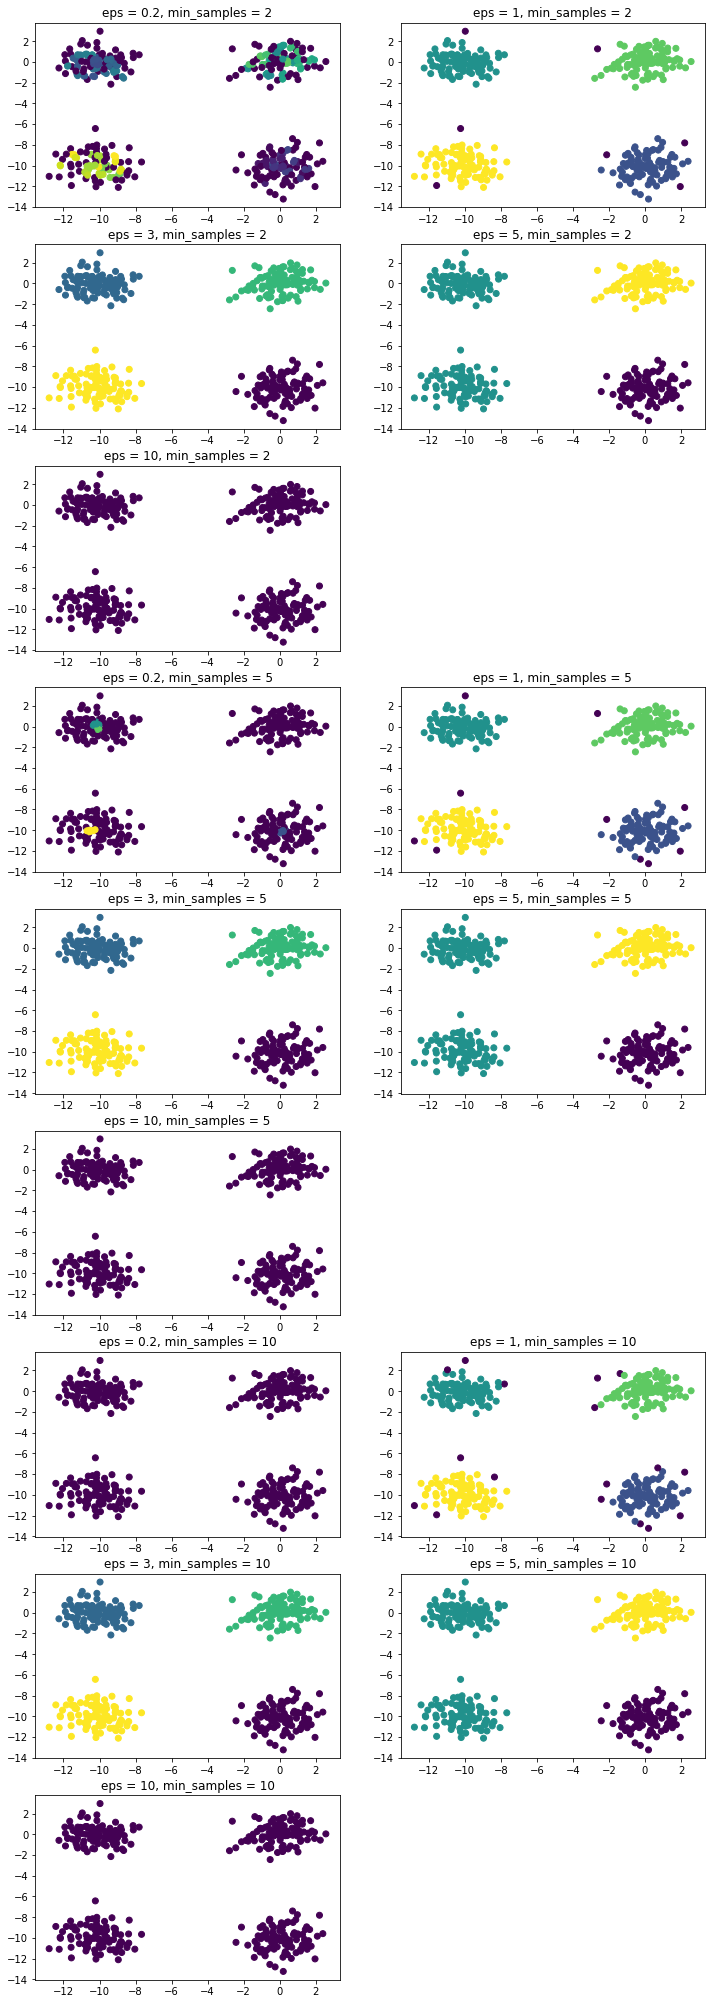

In [ ]:
plt.figure(figsize=(12, 36))
i = 1
for sample in [2, 5, 10]:
  for e in [0.2, 1, 3, 5, 10]:
    dbscan = DBSCAN(eps=e, min_samples=sample)                   #создаем объект класса DBSCAN
    clusters = dbscan.fit_predict(X)                             #передаем все объекты в метод .fit_predict
    plt.subplot(9, 2, i)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)                    #визуализируем результат
    plt.title('eps = {}, min_samples = {}'.format(e, sample))    #подписываем графики
    i += 1
  i += 1
plt.show()

При параметре eps=0.2 алгоритм DBSCAN почти все точки относит к выбросам, при параметре eps=1 алгоритм хорошо справляется и разделяет все точки на четыре кластера, выделяя некоторые точки как выбросы, при увеличении данного параметра некоторые точки перестают выделяться как выбросы, а при еще большем увеличении вообще сокращается количество кластеров до 1, что не является хорошим результатом.

При увеличении параметра min_samples с каждей итерацией при равных eps все меньше точек входит в определенный кластер, что объясняется также "усложнением" условий. 

Результат работы алгоритма зависит от параметров eps и min_samples, при чем для достижения хорошего результата нужно подбирать оба параметра в совокупности. 

**Пример работы алгоритма на данных необычной формы**

Из SKLEARN импортируем библиотеку DATASETS

In [ ]:
from sklearn import datasets

Сгенерируем данные, 500 точек, форма двух полумесяцев. Применим к данным алгоритм DBSCAN, визуализируем и посмотрим, какие получились кластеры.  

Text(0.5, 1.0, 'DBSCAN')

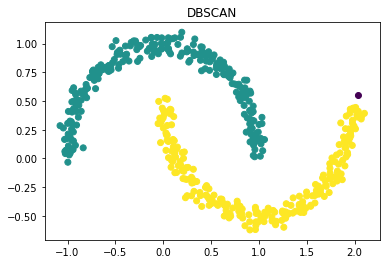

In [ ]:
n_samples = 500                                                  #генерируем 500 точек
X = datasets.make_moons(n_samples=n_samples,  noise = 0.05)            
X = X[0]
dbscan = DBSCAN(eps=0.1, min_samples=5)                          #создаем объект класса DBSCAN
clusters = dbscan.fit_predict(X)                                 #передаем все объекты в метод .fir_predict
plt.scatter(X[:, 0], X[:, 1], c=clusters)                        #визуализируем данные
plt.title('DBSCAN')                                              #подписываем изображение


Наглядно видно, что метод DBSCAN хорошо справился с кластеризацией данных такой необычной формы: некоторые точки определены как выбросы, что является следствием заданных параметров eps и min_samples, но в целом кластеры определены верно. 

Попробуем на этих же данных применить метод кластеризации KMeans. 

Импортируем алгоритм KMeans

In [ ]:
from sklearn.cluster import KMeans

Метод KMeans имеет гиперпараметр - количество кластеров. В данном случае передаем в метод двойку. Визуализируем данные. 

Text(0.5, 1.0, 'KMeans')

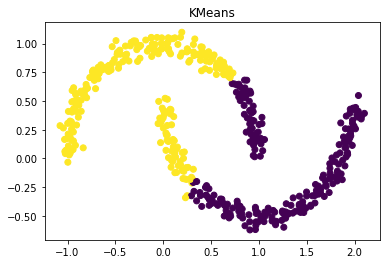

In [ ]:
k_means = KMeans(n_clusters=2)                                   #создаем объект класса KMeans
clusters = k_means.fit_predict(X)                                #передаем все данные в метод .fir_predict
plt.scatter(X[:, 0], X[:, 1], c = clusters)                      #визуализируем данные
plt.title('KMeans')                                              #подписываем изображение

Как видим, алгоритм KMeans не справился с кластеризацией данных такой формы, хотя на входе получил необходимые для этого данные. 

Таким образом, наглядно показано, в каких моментах алгоритм DBSCAN выгодно отличается от некоторых других алгоритмов кластеризации, таких как, например, KMeans.

# Полезные ссылки

Видео с наглядной демонстрацией работы: 

1) https://www.coursera.org/learn/advanced-machine-learning-methods/lecture/ejMhr/dbscan

2) https://www.youtube.com/watch?v=xSKwxoJeYjw

Курс по машинному обучению от ВШЭ, в котором подробно описан данные алгоритм: https://www.coursera.org/learn/advanced-machine-learning-methods/home/welcome

Статьи: 

1) https://habr.com/ru/post/322034/

2) https://www.machinelearningmastery.ru/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d/

3) https://ru.wikipedia.org/wiki/DBSCAN

4) https://github.com/scikit-learn-contrib/hdbscan

Про применение: 

1) http://elib.sfu-kras.ru/handle/2311/21660/discover

2) https://www.machinelearningmastery.ru/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d/

3) https://research.itmo.ru/file/stat/48/mag2021.pdf

4) https://www.coursera.org/lecture/python-for-data-science/praktichieskoie-primienieniie-dbscan-kjhlU

